In [7]:
import optipie as pie

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#DETAILS AND PARAMETERS FOR FUNCTION USING MARKET VARIABLES
TICKER = "^SPX"
type = "call"
expiry = "2024-09-20"

nsdq = yf.Ticker(TICKER)
opt_c = nsdq.option_chain(date = expiry).calls
opt_p = nsdq.option_chain(date = expiry).puts
opt_close = nsdq.history(period = "5y", interval = "1d" ).Close
ret_log = pd.DataFrame(np.log(opt_close/opt_close.shift(1)))
ret_log = ret_log[1:]
vol_an_rol = ret_log.rolling(window=252).std()*np.sqrt(252)

opt_vol = vol_an_rol.iloc[-1,0] # Historic Volatility 
opt_s = opt_close.iloc[-1] # SPOT
opt_kc = opt_c[opt_c.strike>opt_s].strike.iloc[0] #S TIRKE CALL
opt_kp = opt_p[opt_p.strike>opt_s].strike.iloc[0] # STRIKE PUT
rfr = 0.03 # risk free rate

dets_c = opt_c[opt_c.strike == opt_kc] 
dets_p = opt_p[opt_p.strike == opt_kp]

opt_price_c = dets_c.lastPrice.iloc[0] # market price call
opt_price_p = dets_p.lastPrice.iloc[0] # market price put
opt_IV_c = dets_c.impliedVolatility.iloc[0] # implied volatility call
opt_IV_p = dets_p.impliedVolatility.iloc[0] # implied volatility put

print(f"{TICKER} {type} for {expiry}:\nVol: {opt_vol:.4f} \nSpot: {opt_s:.2f} \nStrike: {opt_kc}",
      f"\nMarket Price: {opt_price_c} \nRisk Free: {rfr}")
opt_list = opt_c[["strike", "lastPrice", "impliedVolatility"]]


^SPX call for 2024-09-20:
Vol: 0.1262 
Spot: 5453.94 
Strike: 5455.0 
Market Price: 95.1 
Risk Free: 0.03


In [2]:
#DEMO DETAILS FOR OPTION WITH HISTORIC VOLATILITY

call = pie.options(price = opt_s, strike = opt_kc, expiry= expiry,  
                  risk_free = rfr, volatility = opt_vol, type_opt = type)  # main object definition
put = pie.options(price = opt_s, strike = opt_kc, expiry= expiry, 
                  risk_free = rfr, volatility = opt_vol, type_opt = "put")


call.describe(), put.describe()


((  Type Option      Expiry  Strike      Price
  0        call  2024-09-20  5505.0  56.564833,
              Option     Delta     Gamma      Vega     Theta       Rho
  0  call 2024-09-20  0.518847  0.002934  4.295112 -2.163098  1.073537),
 (  Type Option      Expiry  Strike      Price
  0         put  2024-09-20  5505.0  51.823799,
             Option     Delta     Gamma      Vega     Theta       Rho
  0  put 2024-09-20 -0.481153  0.002934  4.295112 -1.711153 -1.035541))

Returning plot of all Greeks against spot


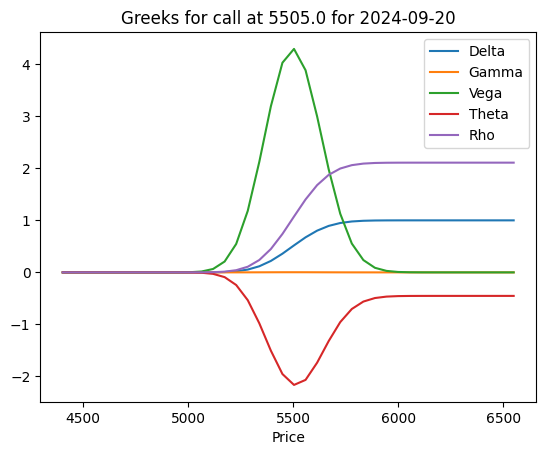

In [3]:
#DEMO PLOT GREEKS

call.plot_greeks(all = 1)

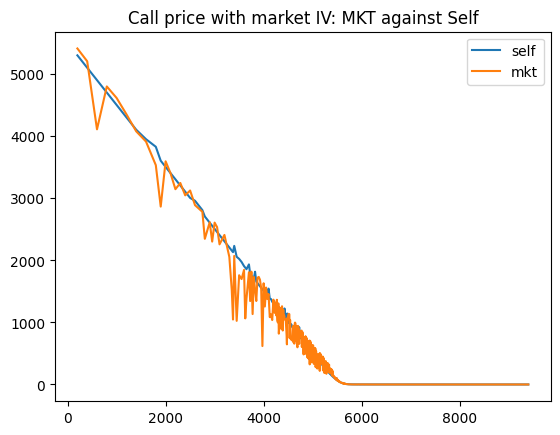

In [4]:
#TEST PRICES CALL AGAINST MARKET USING MARKET IVs
c = []
for y, i in zip(opt_list.strike, opt_list.impliedVolatility):
    p = call.call_price(strike = y,volatility = i)
    c.append(p)
fig, ax = plt.subplots()
ax.plot(opt_list.strike, c, label="self")
ax.plot(opt_list.strike,opt_list.lastPrice, label="mkt")
ax.legend()
plt.title("Call price with market IV: MKT against Self")
plt.show()


Implied Volatility for ^SPX at 61.72: 0.1380 
Implied Volatility market at 61.72: 0.1449


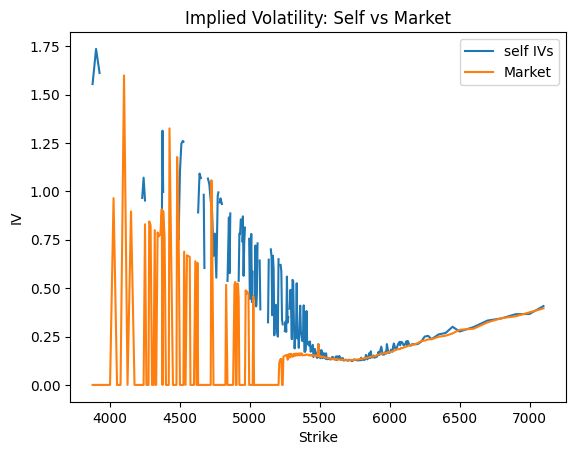

In [5]:
#DEMO PLOT IV
opt_IV = call.IV(mkt_price = opt_price_c)
self_price = call.call_price(volatility = opt_IV)
print(f"Implied Volatility for {TICKER} at {self_price:.2f}: {opt_IV:.4f}",
      f"\nImplied Volatility market at {opt_price_c}: {opt_IV_c:.4f}")

call.plot_IV(name= TICKER, marg = 0.3)